<a href="https://colab.research.google.com/github/LaurentSeguin/Learning_ML/blob/main/Working%20with%20Custom%20Dataset%20In%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importing Libraries

In [1]:
import torch
from torch import nn
device ="cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!nvidia-smi

Tue Feb 25 05:57:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.0 Get the data.

The dataset is a subset of the food101 dataset. It contained only 3 classes of the food and only 10% of the dataset.

When starting out an ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast we can experiment and then scale up.

In [3]:
import requests
import zipfile
from pathlib import Path
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exits... skipping download")
else:
  print(f"{image_path} does not exit,creating one....")
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/LaurentSeguin/Learning_ML/raw/main/datasets/pizza_steak_sushi.zip")
  print("Downloading data.....")
  f.write(request.content)

# unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza,steak and sushi data")
  zip_ref.extractall(image_path)




data/pizza_steak_sushi directory already exits... skipping download
Unzipping pizza,steak and sushi data


## 2.0 Exploring the data and Preparing the data

In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returing its contents"""
  for  dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'. 
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'. 
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'. 
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'. 
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'. 
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'. 
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'. 


In [6]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir =  image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Steps:
  1. Get all of image paths.
  2. Pick a random image path using Python `random.choice()`
  3. Get the image class name using `pathlib.Path.parent.stem`
  4. Open the image with Python's PIL
  5. Show the image  and print metadata

Random Image path: data/pizza_steak_sushi/train/steak/2614189.jpg
Image Class: steak
Image Height: 512
Image Width: 512


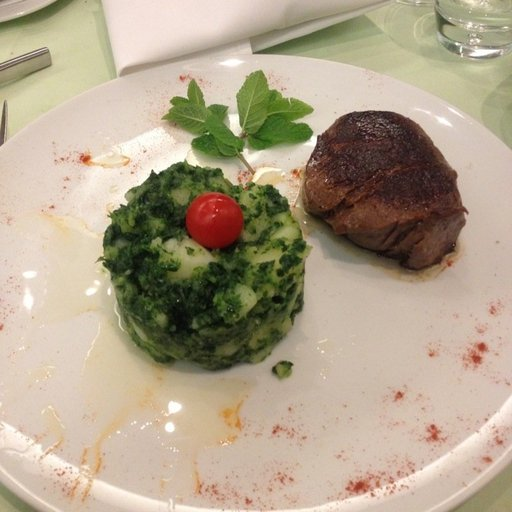

In [7]:
import random
from PIL import Image

# Set random set
#random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # this will look in all the directories and return the path of all files with extension .jpg

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image
img= Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

#### 2.2 Visualizing with Matplotlib

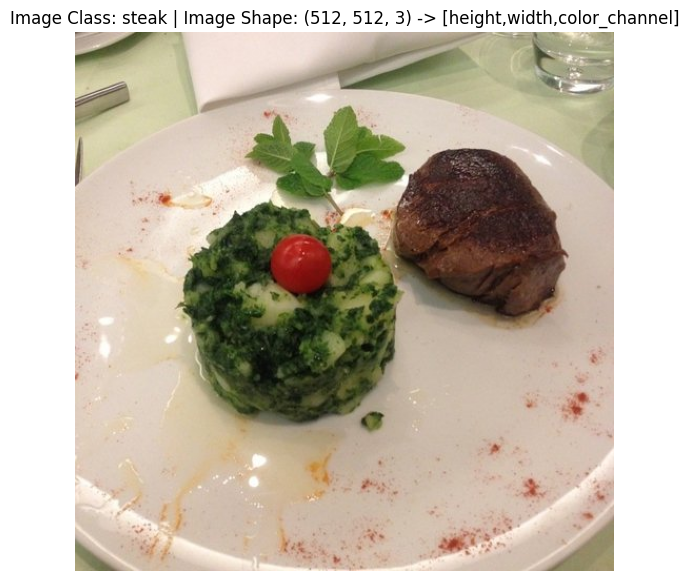

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array  = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height,width,color_channel]")
plt.axis(False);

## 3. Transforming Data

Before using the image data with Pytorch, we need:
  1. To turn the data into tensors
  2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we will call this the `Dataset` and the `Dataloader` respectively.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Transforming the data with `torchvision.transforms`

Transform is used to get your images ready to be used with a model/perform data augmentation.

In [10]:
# Write a transform for image.
# With the following code, we will apply different transforms to the images using transform.Compose
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
#testing the transform function
data_transform(img).shape


torch.Size([3, 64, 64])

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=None):
  """
  Selects random images from a path of images and
  load/transform them,
  then plot the original image v/s the transformed one.
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths,k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Origin Image\nSize:{f.size}")
      ax[0].axis(False)
      # Transform and plot target image
      transform_image = transform(f).permute(1,2,0) # change the shape of the tensor from [c,h,w] to [h,w,c] for matplotlib
      ax[1].imshow(transform_image)
      ax[1].set_title(f"Transformed Image\nSize:{transform_image.shape}")
      ax[1].axis(False)


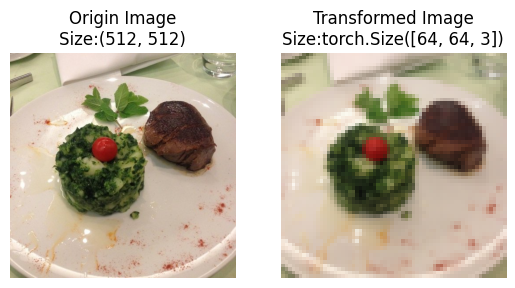

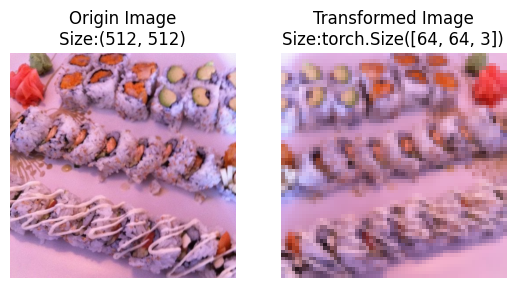

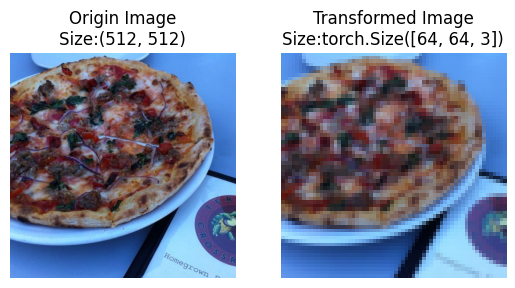

In [13]:
plot_transformed_images(image_path_list,data_transform)

## 4.0 Method 1: Loading images using `ImageFolder`

In [14]:
# Use ImageFolder to create a dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform= data_transform,#transform the data
                                  target_transform=None)# transform the label if required
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our dataset
len(train_data),len(test_data)

(225, 75)

In [18]:
# Check one sample
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on  the train_data dataset to get the image and the label
img,label = train_data[0][0],train_data[0][1]
print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image Label: {label}')
print(f'Label datatype: {type(label)}')


Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original Shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

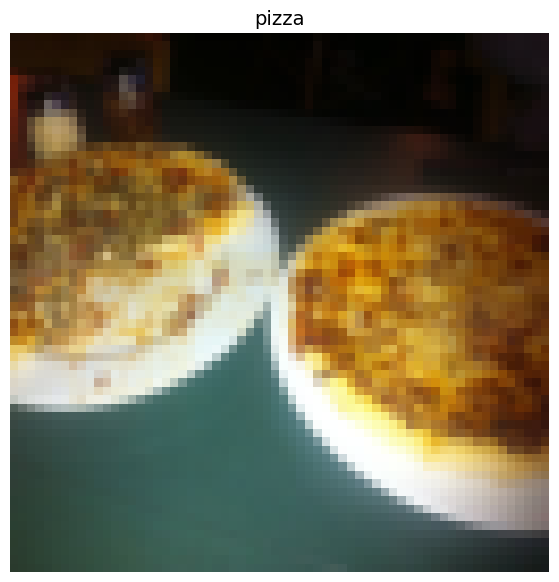

In [20]:
# Rearrange the order dimension for plotting with matplotlib
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original Shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

#### 4.1 Turn loaded images into `Dataloader`
The dataloader helps us to turn our dataset into an iterables and we customize the batch_size

In [21]:
# Turn train and test datasets into Dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)
test_dataloader= DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

In [22]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x782ff6204f50>,
 <torch.utils.data.dataloader.DataLoader at 0x783106b5b3d0>)

In [23]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [24]:
# iterate through the train_dataloader
img,label = next(iter(train_dataloader))
print(f'Image shape: {img.shape}')
print(f'label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64])
label shape: torch.Size([1])


##5.0 Option 2: Loading Image Data with a custom dataset
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset


In [25]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data  import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

#### 5.1 Creating a helper function to get class names in folders

The function should:
  1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format)
  2. Raise an error if the class names aren't found (if this happens, there might br something wrong with the directory structure)
  3. Turn the class names into a dict and a list and return them.

  

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """ Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure")

  # 3. Create a directionary of index labels
  class_to_idx = {class_name:i for i , class_name in enumerate(classes)}
  return classes,class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom datasetm, we need to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we would like to get the data from) as well as a transform if we will like to transform our data.
3. Create several attributes:
  * path- paths of our images
  * transform - the transformation we would like to use.
  * classes - a list of the target classes
  * class_to_idx - a dictionary of the target classes mapped to integer labels.
4. Create a function to `load_images()`, this function will open an images
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [30]:
# 0.  Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Intitialize our custom dataset
  def __init__(self,
              targ_dir:str,
              transform=None) -> None:
    # 3. Create call attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup Transforms
    self.transform = transform
    # Create classes and class_to_idx attriutes
    self.classes, self.class_to_idx = find_classes(targ_dir)
  # 4. Create a function toi load images
  def load_image(self,index: int) -> Image.Image:
    "Opens an image via a path and returns it "
    image_path = self.paths[index]
    return Image.open(image_path)
  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: datafolder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label
    else:
      return img,class_idx




In [31]:
from torchvision import transforms
# Create a tranform
train_transform =transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [33]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x782ff6085d90>,
 <__main__.ImageFolderCustom at 0x782ff622d410>)

In [34]:
len(train_data_custom)

225

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display from getting out of hand, we cap the number of images to visualize at 10.
3. Set a random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through thr random sample images and plot them with matplotlib
7. Make sure the dimensions of the images line up with matplotlib (HWC)


In [37]:
# 1. Create a function to take in a dataset
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int = 10,
                          display_shape:bool=True,
                          seed:int =None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
  # 3. Set Seed
  if seed:
    random.seed(seed)
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)
  # 5. Setup plot
  plt.figure(figsize=(16,8))


  # 6. Loop through random indexes and plot them with matplotlib
  for i,targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0],dataset[targ_sample][1]
    #7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # convert [color_channel,height,width] -> [height,width,color_channel]
    # Plot adjusted sample images
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape:{targ_image_adjust.shape}"
    plt.title(title)


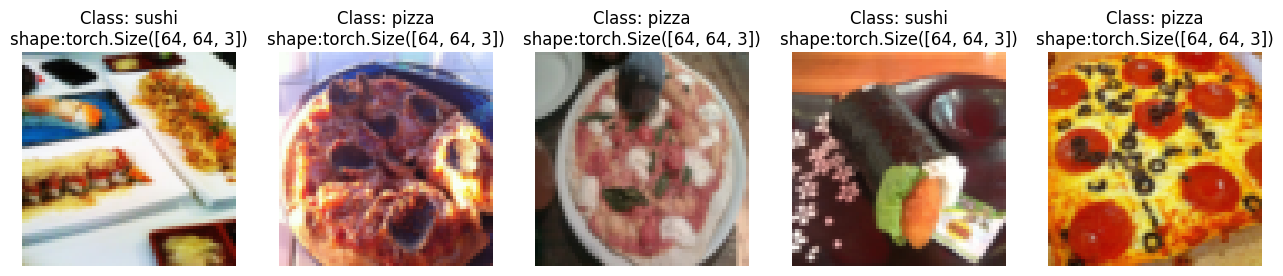

In [38]:
# Display random images from the imagefolder
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


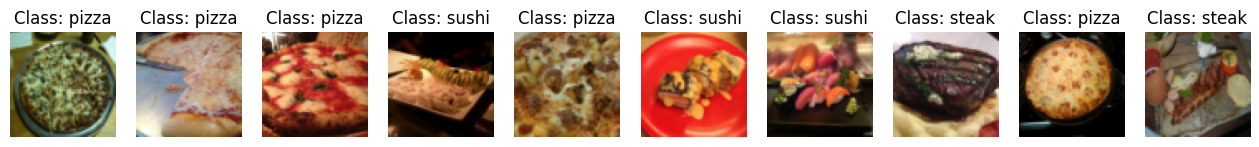

In [39]:
# Display random images from the imagefolder custom
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

### 5.4 Convert custon loaded images into a Dataloader


In [48]:
from torch.utils.data import DataLoader
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [43]:
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x782fe3591e50>,
 <torch.utils.data.dataloader.DataLoader at 0x782fe3a729d0>)

In [49]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
# print out the shape
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))